# Imports

In [2]:
#!pip install statsmodels matplotlib

In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT, LinAlgError
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from pyspark.sql.functions import col
import statsmodels.api as sm
import scipy.stats as scipy_stats
from scipy.stats import t, f

# Initialize Spark session

In [4]:
spark = SparkSession.builder.master("spark://spark-master:7077").appName("ManualQRDecomposition").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/29 06:42:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1) Functions for linear regression with QR decomposition

## 1.1)  Maethematical Core Functions

### 1.1.1) Backward Substitution

In [5]:
def backward_substitution(R, b):
    """
    Solves the upper triangular system Rx = b for x using backward substitution.
    
    Parameters
    ----------
    R : ndarray
        Upper triangular matrix from QR decomposition
    b : ndarray
        The right-hand side vector
        
    Returns
    -------
    ndarray
        Solution vector x that satisfies Rx = b
        
    Notes
    -----
    - Implements classic backward substitution algorithm
    - Includes numerical stability check (threshold of 1e-10)
    - Returns zero for numerically unstable solutions
    """
    n = len(b)
    x = np.zeros(n)
    
    for i in range(n-1, -1, -1):
        sum_val = 0
        for j in range(i+1, n):
            sum_val += R[i, j] * x[j]
        
        if abs(R[i, i]) > 1e-10:
            x[i] = (b[i] - sum_val) / R[i, i]
        else:
            x[i] = 0
            
    return x

### 1.1.2) Gram Schmidt without optimization for Spark

In [ ]:
def gram_schmidt(X):
    """
    Performs classical Gram-Schmidt orthogonalization.
    
    Parameters
    ----------
    X : ndarray
        Input matrix to orthogonalize, shape (n, m)
        
    Returns
    -------
    Q : ndarray
        Orthogonal matrix, shape (n, m)
    R : ndarray
        Upper triangular matrix, shape (m, m)
        
    Notes
    -----
    - Implements classical Gram-Schmidt orthogonalization
    - No explicit numerical stability checks
    - May be less stable than modified Gram-Schmidt for ill-conditioned matrices
    """
    n, m = X.shape
    Q = np.zeros((n, m))
    R = np.zeros((m, m))

    for j in range(m):
        v = X[:, j]
        
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], X[:, j])
            v = v - R[i, j] * Q[:, i]

        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]

    return Q, R

### 1.1.3) Gram Schmidt with optimization for Spark

In [ ]:
def manual_qr_decomposition(X_array):
    """
    Performs QR decomposition using modified Gram-Schmidt with numerical stability handling.
    
    Parameters
    ----------
    X_array : ndarray
        Input matrix to decompose, shape (n, m)
        
    Returns
    -------
    Q : ndarray
        Orthogonal matrix, shape (n, m)
    R : ndarray
        Upper triangular matrix, shape (m, m)
        
    Notes
    -----
    - Implements modified Gram-Schmidt process
    - Includes numerical stability threshold (1e-12)
    - Returns zeros for numerically unstable columns
    """
    n, m = X_array.shape
    Q = np.zeros((n, m))
    R = np.zeros((m, m))
    
    for j in range(m):
        v = X_array[:, j]
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], X_array[:, j])
            v = v - R[i, j] * Q[:, i]
        norm = np.linalg.norm(v)
        if norm > 1e-12:
            Q[:, j] = v / norm
            R[j, j] = norm
        else:
            R[j, j] = 0
    return Q, R

## 1.3) Data Simulation

### 1.3.1) Simulate data set without Spark optimization

In [8]:
def create_data_numpy(n, p, beta_true):
    """
    Generates synthetic regression data using NumPy.
    
    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features (excluding intercept)
    beta_true : ndarray
        True coefficient values including intercept
        
    Returns
    -------
    X : ndarray
        Design matrix with intercept column, shape (n, p+1)
    y : ndarray
        Target variable vector, shape (n,)
        
    Notes
    -----
    - Uses fixed random seed (42) for reproducibility
    - Adds constant term (intercept) to X
    - Adds Gaussian noise with std=0.1 to y
    """
    np.random.seed(42)
    X = np.random.rand(n, p)
    X = np.column_stack([np.ones(X.shape[0]), X])
    y = X @ beta_true + np.random.randn(n) * 0.3
    return X, y

### 1.3.2) Simulate data set with Spark optimization

In [9]:
def create_data_spark(n_samples, n_features, beta_true, noise_std=0.3, partition_size=10000):
    """
    Generates distributed synthetic regression data optimized for Spark.
    
    Parameters
    ----------
    n_samples : int
        Total number of observations
    n_features : int
        Number of features (excluding intercept)
    beta_true : ndarray
        True coefficient values including intercept
    noise_std : float, optional
        Standard deviation of Gaussian noise, default=0.1
    partition_size : int, optional
        Number of samples per partition, default=10000
        
    Returns
    -------
    DataFrame
        Spark DataFrame with features and target columns
        
    Notes
    -----
    - Generates data in parallel across partitions
    - Uses unique random seeds per partition
    - Optimized for distributed processing
    """
    def generate_partition(partition_index, partition_size):
        np.random.seed(42 + partition_index)
        X = np.random.randn(partition_size, n_features)
        X = np.column_stack([np.ones(partition_size), X])
        y = X @ beta_true + np.random.normal(0, noise_std, partition_size)
        return [(Vectors.dense(x), float(y_i)) for x, y_i in zip(X, y)]
    
    num_partitions = max(n_samples // partition_size, spark.sparkContext.defaultParallelism)
    samples_per_partition = n_samples // num_partitions
    
    rdd = (spark.sparkContext
           .parallelize(range(num_partitions), num_partitions)
           .flatMap(lambda i: generate_partition(i, samples_per_partition)))
    
    return spark.createDataFrame(rdd, ["features", "y"])


## 1.4) Model Fitting Functions

### 1.4.1) Function for calculating the statistics

In [10]:
def compute_statistics_numpy(X, y, beta, residuals):
    """
    Computes comprehensive regression statistics using NumPy.
    
    Parameters
    ----------
    X : ndarray
        Design matrix including intercept
    y : ndarray
        Target variable vector
    beta : ndarray
        Estimated coefficients
    residuals : ndarray
        Model residuals (y - X @ beta)
        
    Returns
    -------
    dict
        Dictionary containing various statistics including:
        - R-squared and Adjusted R-squared
        - F-statistic and p-value
        - Standard errors and t-statistics
        - AIC and BIC
        - Durbin-Watson statistic
        - Jarque-Bera test results
        
    Notes
    -----
    - Computes full suite of regression diagnostics
    - Includes both model fit and residual diagnostics
    """
    n, k = X.shape
    SSE = np.sum(residuals ** 2)
    SST = np.sum((y - np.mean(y)) ** 2)
    SSR = SST - SSE
    df_residuals = n - k
    df_model = k - 1
    
    r_squared = 1 - (SSE / SST)
    adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / df_residuals)
    
    MSE = SSE / df_residuals
    MSR = SSR / df_model
    f_statistic = MSR / MSE
    f_p_value = stats.f.sf(f_statistic, df_model, df_residuals)
    
    sigma_squared = MSE
    XtX_inv = np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diag(sigma_squared * XtX_inv))
    t_values = beta / se
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), df_residuals))
    
    skewness = stats.skew(residuals)
    kurtosis = stats.kurtosis(residuals, fisher=False)
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma_squared) + 1)
    AIC = 2 * k - 2 * log_likelihood
    BIC = n * np.log(SSE / n) + k * np.log(n)
    
    dw_statistic = np.sum(np.diff(residuals) ** 2) / SSE
    
    jarque_bera_stat = (n / 6) * (skewness**2 + (kurtosis - 3)**2 / 4)
    prob_jb = 1 - stats.chi2.cdf(jarque_bera_stat, df=2)
    
    return {
        'r_squared': r_squared,
        'Adjusted R-squared': adj_r_squared,
        'F-statistic': f_statistic,
        'Prob (F-statistic)': f_p_value,
        'Log-Likelihood': log_likelihood,
        'AIC': AIC,
        'BIC': BIC,
        'coef': beta,
        'std err': se,
        't': t_values,
        'P>|t|': p_values,
        'Skew': skewness,
        'Kurtosis': kurtosis,
        'Durbin-Watson': dw_statistic,
        'Jarque-Bera (JB)': jarque_bera_stat,
        'Prob(JB)': prob_jb,
        'mse': MSE
    }

In [13]:
 def compute_statistics_partition(iterator, beta):
    """
    Computes partial statistics for a partition of data in Spark.
    
    Parameters
    ----------
    iterator : iterator
        Iterator over partition rows
    beta : ndarray
        Estimated coefficients
        
    Returns
    -------
    tuple
        (SSE_local, SST_local, SSR_local, y_sum_local, count_local)
        Local statistics for the partition
        
    Notes
    -----
    - Designed for distributed computation in Spark
    - Handles empty partitions gracefully
    - Computes sufficient statistics for later aggregation
    """
    rows = list(iterator)
    SSE_local, SST_local, SSR_local = 0, 0, 0
    y_sum_local, count_local = 0, 0

    if len(rows) == 0:
        print("Empty partition in compute_statistics_partition.")
        return (0.0, 0.0, 0.0, 0.0, 0)

    for row in rows:
        y = row.y
        y_sum_local += y
        count_local += 1

    if count_local > 0:
        y_mean_local = y_sum_local / count_local

        for row in rows:
            X = row.features.toArray()
            y = row.y
            y_pred = np.dot(X, beta)
            residual = y - y_pred
            SSE_local += residual ** 2
            SST_local += (y - y_mean_local) ** 2

        SSR_local = SST_local - SSE_local

    return (SSE_local, SST_local, SSR_local, y_sum_local, count_local)

In [14]:
def aggregate_statistics(rdd_stats, n, beta_length, XtX_inv, residuals, beta):
    """
    Aggregates statistics across all partitions in Spark.
    
    Parameters
    ----------
    rdd_stats : RDD
        RDD containing partial statistics from each partition
    n : int
        Total number of samples
    beta_length : int
        Number of coefficients (including intercept)
        
    Returns
    -------
    dict
        Aggregated statistics including:
        - R-squared and Adjusted R-squared
        - F-statistic
        - AIC and BIC
        - Sample size and feature count
        
    Notes
    -----
    - Implements safe reduction operations
    - Handles edge cases and potential errors
    - Includes comprehensive error checking
    """
    def safe_reduce(a, b):
        try:
            return (
                a[0] + b[0],
                a[1] + b[1],
                a[2] + b[2],
                a[3] + b[3],
                a[4] + b[4]
            )
        except (IndexError, TypeError) as e:
            print(f"Error in safe_reduce: {str(e)}")
            return a

    try:
        (SSE, SST, SSR, y_sum_total, total_count) = rdd_stats.reduce(safe_reduce)
    except Exception as e:
        print(f"Error in aggregating statistics: {str(e)}")
        return {}

    y_mean = y_sum_total / total_count if total_count > 0 else 0

    r_squared = 1 - (SSE / SST) if SST > 0 else 0
    adj_r_squared = (
        1 - ((1 - r_squared) * (total_count - 1) / (total_count - beta_length))
        if total_count > beta_length else 0
    )

    MSE = SSE / (total_count - beta_length) if total_count > beta_length else 0
    MSR = SSR / (beta_length - 1) if beta_length > 1 else 0
    df_model = beta_length - 1
    df_residuals = total_count - beta_length
    f_statistic = MSR / MSE if MSE > 0 else float('inf')
    f_p_value = scipy_stats.f.sf(f_statistic, df_model, df_residuals)
    log_likelihood = -0.5 * total_count * (np.log(2 * np.pi * MSE) + 1) if MSE > 0 else float('-inf')

    AIC = total_count * np.log(SSE / total_count) + 2 * beta_length if total_count > 0 else 0
    BIC = total_count * np.log(SSE / total_count) + beta_length * np.log(total_count) if total_count > 0 else 0

    sigma_squared = MSE
    XtX_inv = XtX_inv
    std_err = np.sqrt(np.diag(sigma_squared * XtX_inv)) if XtX_inv is not None else [float('nan')] * beta_length
    dw_statistic = np.sum(np.diff(residuals) ** 2) / SSE
    skewness = scipy_stats.skew(residuals)
    kurtosis = scipy_stats.kurtosis(residuals, fisher=False)
    jb_statistic = (n / 6) * (skewness**2 + (kurtosis - 3)**2 / 4)
    prob_jb = 1 - scipy_stats.chi2.cdf(jb_statistic, df=2)
    skew = scipy_stats.skew(residuals)
    kurtosis = scipy_stats.kurtosis(residuals, fisher=False)
    t_values = beta / std_err
    p_values = 2 * (1 - scipy_stats.t.cdf(np.abs(t_values), df_residuals))

    stats = {
    'r_squared': r_squared,
    'Adjusted R-squared': adj_r_squared,
    'F-statistic': f_statistic,
    'Prob (F-statistic)': f_p_value,
    'Log-Likelihood': log_likelihood,
    'AIC': AIC,
    'BIC': BIC,
    'SSE': SSE,
    'SSR': SSR,
    'SST': SST,
    'mse': MSE,
    'n_samples': total_count,
    'n_features': beta_length,
    'std err': std_err,
    't': t_values,
    'P>|t|': p_values,
    'Durbin-Watson': dw_statistic,
    'Jarque-Bera (JB)': jb_statistic,
    'Prob(JB)': prob_jb,
    'Skew': skew,
    'Kurtosis': kurtosis
}


    return stats

### 1.4.2)  Linear regression with NumPy

In [15]:
def linear_regression_manual_qr(X, y):
    """
    Fits linear regression using manual QR decomposition.
    
    Parameters
    ----------
    X : ndarray
        Design matrix including intercept
    y : ndarray
        Target variable vector
        
    Returns
    -------
    dict
        Regression results including coefficients and statistics
    float
        Computation time in seconds
        
    Notes
    -----
    - Uses Gram-Schmidt QR decomposition
    - Computes comprehensive statistics
    - Includes timing information
    """
    start_time = time.time()
    Q, R = gram_schmidt(X)
    beta = backward_substitution(R, Q.T @ y)

    y_pred = np.dot(X, beta)
    residuals = y - y_pred

    result = compute_statistics_numpy(X, y, beta, residuals)
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    return result, elapsed_time

### 1.4.3) Linear regression optimized for Spark with manual QR decomposition

In [1]:
def fit_ols_manual(df):
    """
    Fits distributed OLS regression using manual QR decomposition in Spark.
    
    Parameters
    ----------
    df : DataFrame
        Spark DataFrame with features and target columns
        
    Returns
    -------
    ndarray
        Estimated coefficients
    dict
        Regression statistics
        
    Notes
    -----
    - Implements distributed QR decomposition
    - Handles computation in partitions
    - Includes timing information
    """
    start_time = time.time()

    def process_partition(iterator):
        X_local, y_local = [], []
        for row in iterator:
            X_local.append(row.features.toArray())
            y_local.append(row.y)

        if not X_local:
            print("Empty partition encountered in process_partition.")
            return [(np.zeros((1, 1)), np.zeros(1))]
        X_local = np.vstack(X_local)
        y_local = np.array(y_local)

        Q_local, R_local = manual_qr_decomposition(X_local)

        Qty_local = np.dot(Q_local.T, y_local)

        return [(R_local, Qty_local)]

    results = df.rdd.mapPartitions(process_partition).filter(lambda x: len(x) > 0).reduce(
        lambda a, b: (
            a[0] + b[0] if isinstance(a[0], np.ndarray) and isinstance(b[0], np.ndarray) else np.zeros((1, 1)),
            a[1] + b[1] if isinstance(a[1], np.ndarray) and isinstance(b[1], np.ndarray) else np.zeros(1)
        )
    )

    R_total, Qty_total = results

    _, R_final = manual_qr_decomposition(R_total)
    beta = backward_substitution(R_final, Qty_total)

    rdd_stats = df.rdd.mapPartitions(lambda iter: [compute_statistics_partition(iter, beta)])
    X = np.array(df.select("features").rdd.map(lambda row: row[0].toArray()).collect())  # Or however X is obtained
    XtX_inv = np.linalg.inv(np.dot(X.T, X))
    y_pred = np.dot(X, beta)
    residuals = df.select("y").rdd.map(lambda row: row[0]).collect() - y_pred  # Calculate residuals

    stats = aggregate_statistics(rdd_stats, n=df.count(), beta_length=len(beta), XtX_inv=XtX_inv, residuals=residuals, beta=beta)

    computation_time = time.time() - start_time
    stats['computation_time'] = computation_time
    
    return beta, stats

### 1.4.4) Linear regression optimized for Spark with built-in functions for QR decomposition


In [17]:
def fit_ols_spark(df):
    """
    Fits linear regression using Spark's built-in implementation.
    
    Parameters
    ----------
    df : DataFrame
        Spark DataFrame with features and target columns
        
    Returns
    -------
    LinearRegressionModel
        Fitted Spark linear regression model
    LinearRegressionTrainingSummary
        Training summary with model statistics
        
    Notes
    -----
    - Uses Spark's MLlib implementation
    - Uses QR decomposition solver
    - Provides standard Spark model metrics
    """
    lr = LinearRegression(featuresCol="features", labelCol="y", solver="normal")
    model = lr.fit(df)
    
    training_summary = model.summary
    
    return model, training_summary


## 1.5) Function for performing the benchmarks

### 1.5.1) Formatting the statistics

In [18]:
def format_summary(beta, statistics, computation_time, X):
    """
    Formats regression results to match statsmodels summary output.
    
    Parameters
    ----------
    beta : ndarray
        Estimated coefficients
    statistics : dict
        Dictionary of computed statistics
    computation_time : float
        Model fitting time in seconds
    X : ndarray
        Design matrix used in the regression
        
    Returns
    -------
    str
        Formatted summary string
    """
    n_obs = statistics['n_samples']
    df_residuals = n_obs - len(beta)
    df_model = len(beta) - 1
    
    summary = []
    summary.append("=" * 78)
    summary.append("{: ^78}".format("OLS Regression Results"))
    summary.append("=" * 78)
    
    current_time = time.localtime()
    formatted_date = time.strftime("%a, %d %b %Y", current_time)
    formatted_time = time.strftime("%H:%M:%S", current_time)
    
    summary.append("{:<20} {:<12} {:<20} {: >20.3f}".format(
        "Dep. Variable:", "y",
        "R-squared:", statistics['r_squared']))
    
    summary.append("{:<20} {:<12} {:<20} {: >20.3f}".format(
        "Model:", "OLS",
        "Adj. R-squared:", statistics['Adjusted R-squared']))
    
    summary.append("{:<20} {:<12} {:<20} {: >20.3e}".format(
        "Method:", "Least Squares",
        "F-statistic:", statistics['F-statistic']))
    
    summary.append("{:<20} {:<12} {:<20} {: >20.3e}".format(
        "Date:", formatted_date,
        "Prob (F-statistic):", statistics['Prob (F-statistic)']))
    
    summary.append("{:<20} {:<12} {:<20} {: >20.3f}".format(
        "Time:", formatted_time,
        "Log-Likelihood:", statistics['Log-Likelihood']))
    
    summary.append("{:<20} {:<12} {:<20} {: >20.3f}".format(
        "No. Observations:", str(n_obs),
        "AIC:", statistics['AIC']))
    
    summary.append("{:<20} {:<12} {:<20} {: >20.3f}".format(
        "Df Residuals:", str(df_residuals),
        "BIC:", statistics['BIC']))
    
    summary.append("{:<20} {:<12}".format(
        "Df Model:", str(df_model)))
    
    summary.append("Covariance Type:            nonrobust")
    
    summary.append("=" * 78)
    summary.append("{:>16} {:>10} {:>10} {:>10} {:>12} {:>10} {:>10}".format(
        "", "coef", "std err", "t", "P>|t|", "[0.025", "0.975]"))
    summary.append("-" * 78)
    
    var_names = ["const"] + [f"x{i+1}" for i in range(len(beta)-1)]
    for i, name in enumerate(var_names):
        conf_int_lower = beta[i] - 1.96 * statistics['std err'][i]
        conf_int_upper = beta[i] + 1.96 * statistics['std err'][i]
        summary.append("{:>16} {: >9.4f} {: >9.3f} {: >10.3f} {: >11.3f} {: >9.3f} {: >9.3f}".format(
            name,
            beta[i],
            statistics['std err'][i],
            statistics['t'][i],
            statistics['P>|t|'][i],
            conf_int_lower,
            conf_int_upper
        ))
    
    summary.append("=" * 78)
    summary.append("{:<21} {: >10.3f} {:<24} {: >19.3f}".format(
        "Durbin-Watson:", statistics['Durbin-Watson'],
        "Jarque-Bera (JB):", statistics['Jarque-Bera (JB)']))
    
    summary.append("{:<21} {: >10.3f} {:<24} {: >19.3f}".format(
        "Prob(JB):", statistics['Prob(JB)'],
        "Skew:", statistics['Skew']))
    
    summary.append("{:<21} {: >10.3f} {:<24} {: >19.3f}".format(
        "Kurtosis:", statistics['Kurtosis'],
        "Cond. No.:", np.linalg.cond(X)))
    
    summary.append("=" * 78)
    summary.append("[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.")
    
    return "\n".join(summary)


### 1.5.2) Calculation with Numpy approach

In [27]:
def run_benchmark_numpy(n_list, beta_true, p, repetitions=10):
    """
    Runs benchmarking for different implementations of linear regression.
    
    Parameters
    ----------
    n_list : list
        Sample sizes to test
    p : int
        Number of features
    beta_true : ndarray
        True coefficients for data generation
    repetitions : int, optional
        Number of benchmark repetitions, default=10
        
    Returns
    -------
    DataFrame
        Benchmark results including:
        - Sample sizes
        - Mean and std of computation times
        - Mean and std of R-squared values
        - Success rates
        
    Notes
    -----
    - Includes error handling
    - Prints progress information
    - Generates comprehensive summaries
    """
    results = [] 

    for n in n_list:
        times = []
        r_squared_values = []
        print(f"\nBenchmarking for n={n:,} samples...")

        for i in range(repetitions):
            X = np.hstack([np.ones((n, 1)), np.random.randn(n, p)]) 
            y = X @ beta_true + np.random.normal(0, 0.1, n)
            
            result, elapsed_time = linear_regression_manual_qr(X, y)
            times.append(elapsed_time)
            r_squared_values.append(result['r_squared'])

        avg_time = np.mean(times)
        avg_r_squared = np.mean(r_squared_values)
        std_time = np.std(times)
        std_r_squared = np.std(r_squared_values)

        avg_statistics = {
            'n_samples': n,
            'SSE': np.sum((y - X @ result['coef']) ** 2),
            'r_squared': result['r_squared'],
            'Adjusted R-squared': result['Adjusted R-squared'],
            'F-statistic': result['F-statistic'],
            'Prob (F-statistic)': result['Prob (F-statistic)'],
            'Log-Likelihood': result['Log-Likelihood'],
            'AIC': result['AIC'],
            'BIC': result['BIC'],
            'coef': result['coef'],
            'std err': result['std err'],
            't': result['t'],
            'P>|t|': result['P>|t|'],
            'Skew': result['Skew'],
            'Kurtosis': result['Kurtosis'],
            'Durbin-Watson': result['Durbin-Watson'],
            'Jarque-Bera (JB)': result['Jarque-Bera (JB)'],
            'Prob(JB)': result['Prob(JB)'],
            'mse': result['mse']
        }

        print("\nSummary for final run:")
        summary_str = format_summary(result['coef'], avg_statistics, avg_time)
        print(summary_str)

        results.append({
            'n_samples': n,
            'n_features': p,
            'mean_time': avg_time,
            'std_time': std_time,
            'mean_r_squared': avg_r_squared,
            'std_r_squared': std_r_squared
        })
        
        print(f"\nSummary for n={n:,}:")
        print(f"  Mean time: {avg_time:.2f}s ± {std_time:.2f}s")
        print(f"  Mean R²: {avg_r_squared:.4f} ± {std_r_squared:.4f}")

    return pd.DataFrame(results)


### 1.5.3) Calculation with Spark with manual QR decomposition

In [20]:
def run_benchmark_point(n, p, true_coefficients, repetitions=10):
    """
    Runs benchmarking for different implementations of linear regression.
    
    Parameters
    ----------
    n : int
        Sample size(s) to test
    p : int
        Number of features
    beta_true : ndarray
        True coefficients for data generation
    repetitions : int, optional
        Number of benchmark repetitions, default=10
        
    Returns
    -------
    DataFrame
        Benchmark results including:
        - Sample sizes
        - Mean and std of computation times
        - Mean and std of R-squared values
        - Success rates
        
    Notes
    -----
    - Includes error handling
    - Prints progress information
    - Generates comprehensive summaries
    """
    times = []
    r_squares = []
    successful_runs = 0

    print(f"\nBenchmarking n={n:,} samples...")
    
    for i in range(repetitions):
        try:
            start_data_creation = time.time()
            df = create_data_spark(n, p, true_coefficients)
            end_data_creation = time.time()

            start_fit = time.time()
            beta, summary = fit_ols_manual(df)
            end_fit = time.time()
            
            elapsed_time = end_fit - start_data_creation
            times.append(elapsed_time)
            r_squares.append(summary['r_squared'])
            successful_runs += 1
            
            print(f"  Run {i+1}: time={elapsed_time:.2f}s, R²={summary['r_squared']:.4f}")
            
        except Exception as e:
            print(f"  Run {i+1} failed: {str(e)}")
    
    if successful_runs > 0:
        result = {
            'n_samples': n,
            'n_features': p,
            'mean_time': np.mean(times),
            'std_time': np.std(times),
            'mean_r_squared': np.mean(r_squares),
            'std_r_squared': np.std(r_squares),
            'successful_runs': successful_runs
        }
        print(format_summary(beta, summary, result['mean_time']))
        print(f"\nSummary for n={n:,}:")
        print(f"  Mean time: {result['mean_time']:.2f}s ± {result['std_time']:.2f}s")
        print(f"  Mean R²: {result['mean_r_squared']:.4f} ± {result['std_r_squared']:.4f}")
    
    return pd.DataFrame([result])


### 1.5.4)Calculation for Spark's built-in functions for QR decomposition

In [22]:
def run_benchmark_spark(n, p, beta_true, repetitions=10):
    """
    Runs benchmarking for different implementations of linear regression.
    
    Parameters
    ----------
    n : int
        Sample size(s) to test
    p : int
        Number of features
    beta_true : ndarray
        True coefficients for data generation
    repetitions : int, optional
        Number of benchmark repetitions, default=10
        
    Returns
    -------
    DataFrame
        Benchmark results including:
        - Sample sizes
        - Mean and std of computation times
        - Mean and std of R-squared values
        - Success rates
        
    Notes
    -----
    - Includes error handling
    - Prints progress information
    - Generates comprehensive summaries
    """
    times = []
    r_squares = []
    successful_runs = 0
    results = []

    print(f"\nBenchmarking for n={n:,} samples...")

    for i in range(repetitions):
        try:
            start_data_creation = time.time()
            df = create_data_spark(n, p, beta_true)
            end_data_creation = time.time()

            start_fit = time.time()
            model, summary = fit_ols_spark(df)
            end_fit = time.time()

            elapsed_time = end_fit - start_data_creation
            times.append(elapsed_time)
            r_squares.append(summary.r2)
            successful_runs += 1

            print(f"  Run {i+1}: time={elapsed_time:.2f}s, R²={summary.r2:.4f}, Adjusted R²={summary.r2adj:.4f}")

        except Exception as e:
            print(f"  Run {i+1} failed: {str(e)}")

    
    if successful_runs > 0:
        result = {
        'n_samples': n,
        'n_features': p,
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'mean_r_squared': np.mean(r_squares),
        'std_r_squared': np.std(r_squares),
        'successful_runs': successful_runs
    }

        print(f"\nSummary for n={n:,}:")
        print(f"  Mean time: {result['mean_time']:.2f}s ± {result['std_time']:.2f}s")
        print(f"  Mean R²: {result['mean_r_squared']:.4f} ± {result['std_r_squared']:.4f}")
    
    return pd.DataFrame([result])


# 2) Carrying out the benchmark and outputting the results

## 2.1) Calculation

In [28]:
n_values = [200000, 500000, 1000000, 5000000, 10000000]
n_features = 10
beta_true = np.random.randn(n_features + 1)

In [29]:
n_values2 = [15000000, 20000000, 25000000, 30000000, 35000000]

### 2.1.1) Numpy

In [30]:
results_numpy = run_benchmark_numpy(n_list=n_values, beta_true=beta_true, p=n_features) 


Benchmarking for n=200,000 samples...

Summary for final run:
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    2.082e+07
Date:                Tue, 29 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                06:46:28     Log-Likelihood:                176710.777
No. Observations:    200000       AIC:                          -353388.554
Df Residuals:        199989       BIC:                          -920862.701
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const    0.0973     0.000    435.045       0.000     0.097     0.098
     

In [61]:
results_numpy

,n_samples,n_features,mean_time,std_time,mean_r_squared,std_r_squared
0,200000,10,0.264353,0.176450,0.999040,3.983148e-06
1,500000,10,0.545938,0.211107,0.999042,2.227146e-06
2,1000000,10,0.919593,0.188071,0.999040,1.557318e-06
3,5000000,10,4.930542,0.650629,0.999040,8.271204e-07
4,10000000,10,9.140280,0.489890,0.999040,6.316811e-07


In [31]:
results_numpy2 = run_benchmark_numpy(n_list=n_values2, beta_true=beta_true, p=n_features)


Benchmarking for n=15,000,000 samples...

Summary for final run:
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    1.561e+09
Date:                Tue, 29 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                06:53:34     Log-Likelihood:              13257322.666
No. Observations:    15000000     AIC:                        -26514612.332
Df Residuals:        14999989     BIC:                        -69082619.569
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const    0.0977     0.000   3782.856       0.000     0.098     0.098
  

In [62]:
results_numpy_df = pd.concat([results_numpy, results_numpy2], ignore_index=True)

In [66]:
results_numpy_df

,n_samples,n_features,mean_time,std_time,mean_r_squared,std_r_squared
0,200000,10,0.264353,0.176450,0.999040,3.983148e-06
1,500000,10,0.545938,0.211107,0.999042,2.227146e-06
2,1000000,10,0.919593,0.188071,0.999040,1.557318e-06
3,5000000,10,4.930542,0.650629,0.999040,8.271204e-07
4,10000000,10,9.140280,0.489890,0.999040,6.316811e-07
5,15000000,10,12.722001,0.267729,0.999040,1.974655e-07
6,20000000,10,16.073033,0.212598,0.999040,4.352536e-07
7,25000000,10,19.955422,0.188008,0.999040,2.781232e-07
8,30000000,10,24.019758,0.159221,0.999040,2.755813e-07
9,35000000,10,29.157389,1.294133,0.999040,2.449528e-07


### 2.1.2)  Spark with manual QR decomposition

In [32]:
results_point = []
results_point = [run_benchmark_point(n=n, p=n_features, true_coefficients=beta_true) for n in n_values]


Benchmarking n=200,000 samples...


  Run 1: time=16.52s, R²=0.9990


  Run 2: time=5.55s, R²=0.9990


  Run 3: time=5.20s, R²=0.9990


  Run 4: time=4.73s, R²=0.9990


  Run 5: time=4.32s, R²=0.9990


  Run 6: time=4.14s, R²=0.9990


  Run 7: time=4.04s, R²=0.9990


  Run 8: time=4.08s, R²=0.9990


  Run 9: time=3.98s, R²=0.9990


  Run 10: time=4.10s, R²=0.9990
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    2.086e+07
Date:                Tue, 29 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                07:18:16     Log-Likelihood:                176894.633
No. Observations:    200000       AIC:                          -921342.680
Df Residuals:        199989       BIC:                          -921230.413
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const    0.0979     0.000    438.304       0.000     0.097     0.098
              x1   -1.1889     0.000

  Run 1: time=8.71s, R²=0.9990


  Run 2: time=8.78s, R²=0.9990


  Run 3: time=8.77s, R²=0.9990


  Run 4: time=8.60s, R²=0.9990


  Run 5: time=8.68s, R²=0.9990


  Run 6: time=8.49s, R²=0.9990


  Run 7: time=8.43s, R²=0.9990


  Run 8: time=9.62s, R²=0.9990


  Run 9: time=9.37s, R²=0.9990


  Run 10: time=9.20s, R²=0.9990
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    5.220e+07
Date:                Tue, 29 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                07:19:45     Log-Likelihood:                442861.348
No. Observations:    500000       AIC:                         -2304639.229
Df Residuals:        499989       BIC:                         -2304516.883
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const    0.0977     0.000    692.367       0.000     0.097     0.098
              x1   -1.1890     0.000

  Run 1: time=17.51s, R²=0.9990


  Run 2: time=17.49s, R²=0.9990


  Run 3: time=16.22s, R²=0.9990


  Run 4: time=16.44s, R²=0.9990


  Run 5: time=16.76s, R²=0.9990


  Run 6: time=16.42s, R²=0.9990


  Run 7: time=16.21s, R²=0.9990


  Run 8: time=16.29s, R²=0.9990


  Run 9: time=16.16s, R²=0.9990


  Run 10: time=16.25s, R²=0.9990
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    1.040e+08
Date:                Tue, 29 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                07:22:31     Log-Likelihood:                884632.775
No. Observations:    1000000      AIC:                         -4607120.617
Df Residuals:        999989       BIC:                         -4606990.647
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const    0.0976     0.000    976.659       0.000     0.097     0.098
              x1   -1.1890     0.00

  Run 1: time=84.95s, R²=0.9990


  Run 2: time=81.72s, R²=0.9990


  Run 3: time=78.76s, R²=0.9990


  Run 4: time=78.93s, R²=0.9990


  Run 5: time=79.08s, R²=0.9990


  Run 6: time=79.08s, R²=0.9990


  Run 7: time=79.25s, R²=0.9990


  Run 8: time=81.17s, R²=0.9990


  Run 9: time=79.90s, R²=0.9990


  Run 10: time=78.47s, R²=0.9990
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    5.201e+08
Date:                Tue, 29 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                07:35:53     Log-Likelihood:               4418273.642
No. Observations:    5000000      AIC:                        -23025910.616
Df Residuals:        4999989      BIC:                        -23025762.942
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const    0.0977     0.000   2183.777       0.000     0.098     0.098
              x1   -1.1890     0.00

  Run 1: time=158.78s, R²=0.9990


  Run 2: time=158.72s, R²=0.9990


  Run 3: time=159.89s, R²=0.9990


  Run 4: time=158.00s, R²=0.9990


  Run 5: time=157.91s, R²=0.9990


  Run 6: time=164.76s, R²=0.9990


  Run 7: time=161.06s, R²=0.9990


  Run 8: time=158.68s, R²=0.9990


  Run 9: time=159.06s, R²=0.9990


  Run 10: time=159.05s, R²=0.9990
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    1.040e+09
Date:                Tue, 29 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                08:02:32     Log-Likelihood:               8836217.233
No. Observations:    10000000     AIC:                        -46051183.131
Df Residuals:        9999989      BIC:                        -46051027.832
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const    0.0977     0.000   3088.355       0.000     0.098     0.098
              x1   -1.1890     0.0

In [33]:
results_point2 = [run_benchmark_point(n=n, p=n_features, true_coefficients=beta_true) for n in n_values2]


Benchmarking n=15,000,000 samples...


  Run 1: time=236.37s, R²=0.9990


  Run 2: time=230.77s, R²=0.9990


  Run 3: time=231.09s, R²=0.9990


  Run 4: time=230.26s, R²=0.9990


  Run 5: time=231.09s, R²=0.9990


  Run 6: time=231.96s, R²=0.9990


  Run 7: time=230.45s, R²=0.9990


  Run 8: time=230.35s, R²=0.9990


  Run 9: time=229.82s, R²=0.9990


  Run 10: time=229.73s, R²=0.9990
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    1.560e+09
Date:                Tue, 29 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                08:41:09     Log-Likelihood:              13253276.389
No. Observations:    15000000     AIC:                        -69074686.774
Df Residuals:        14999989     BIC:                        -69074527.015
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const    0.0976     0.000   3779.938       0.000     0.098     0.098
              x1   -1.1890     0.0

  Run 1: time=308.79s, R²=0.9990


  Run 2: time=306.01s, R²=0.9990


  Run 3: time=306.56s, R²=0.9990


  Run 4: time=306.28s, R²=0.9990


  Run 5: time=306.27s, R²=0.9990


  Run 6: time=306.38s, R²=0.9990


  Run 7: time=306.62s, R²=0.9990


  Run 8: time=305.95s, R²=0.9990


  Run 9: time=307.10s, R²=0.9990


  Run 10: time=306.04s, R²=0.9990
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    2.080e+09
Date:                Tue, 29 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                09:32:24     Log-Likelihood:              17673725.547
No. Observations:    20000000     AIC:                        -92104970.421
Df Residuals:        19999989     BIC:                        -92104807.498
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const    0.0976     0.000   4365.839       0.000     0.098     0.098
              x1   -1.1890     0.0

  Run 1: time=384.82s, R²=0.9990


  Run 2: time=382.78s, R²=0.9990


  Run 3: time=382.60s, R²=0.9990


  Run 4: time=384.18s, R²=0.9990


  Run 5: time=383.43s, R²=0.9990


  Run 6: time=384.18s, R²=0.9990


  Run 7: time=384.93s, R²=0.9990


  Run 8: time=385.43s, R²=0.9990


  Run 9: time=385.53s, R²=0.9990


  Run 10: time=394.05s, R²=0.9990
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    2.600e+09
Date:                Tue, 29 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                10:36:48     Log-Likelihood:              22090627.077
No. Observations:    25000000     AIC:                       -115128158.815
Df Residuals:        24999989     BIC:                       -115127993.437
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const    0.0976     0.000   4881.177       0.000     0.098     0.098
              x1   -1.1890     0.0

  Run 1: time=457.34s, R²=0.9990


  Run 2: time=450.35s, R²=0.9990


  Run 3: time=452.71s, R²=0.9990


  Run 4: time=450.74s, R²=0.9990


  Run 5: time=451.12s, R²=0.9990


  Run 6: time=451.83s, R²=0.9990


  Run 7: time=460.55s, R²=0.9990


  Run 8: time=455.41s, R²=0.9990


  Run 9: time=461.84s, R²=0.9990


  Run 10: time=457.08s, R²=0.9990
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    3.120e+09
Date:                Tue, 29 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                11:52:54     Log-Likelihood:              26509619.951
No. Observations:    30000000     AIC:                       -138155529.894
Df Residuals:        29999989     BIC:                       -138155362.511
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const    0.0976     0.000   5346.937       0.000     0.098     0.098
              x1   -1.1890     0.0

  Run 1: time=535.97s, R²=0.9990


  Run 2: time=526.54s, R²=0.9990


  Run 3: time=532.37s, R²=0.9990


  Run 4: time=533.06s, R²=0.9990


  Run 5: time=532.52s, R²=0.9990


  Run 6: time=533.57s, R²=0.9990


  Run 7: time=533.06s, R²=0.9990


  Run 8: time=532.68s, R²=0.9990


  Run 9: time=533.81s, R²=0.9990


  Run 10: time=532.71s, R²=0.9990
                            OLS Regression Results                            
Dep. Variable:       y            R-squared:                          0.999
Model:               OLS          Adj. R-squared:                     0.999
Method:              Least Squares F-statistic:                    3.641e+09
Date:                Tue, 29 Oct 2024 Prob (F-statistic):             1.110e-16
Time:                13:22:01     Log-Likelihood:              30926362.416
No. Observations:    35000000     AIC:                       -161178400.156
Df Residuals:        34999989     BIC:                       -161178231.077
Df Model:            10          
Covariance Type:            nonrobust
                       coef    std err          t        P>|t|     [0.025     0.975]
------------------------------------------------------------------------------
           const    0.0976     0.000   5775.426       0.000     0.098     0.098
              x1   -1.1890     0.0

In [50]:
results_point_df = pd.concat(results_point , ignore_index=True)

,n_samples,n_features,mean_time,std_time,mean_r_squared,std_r_squared,successful_runs
0,200000,10,5.666338,3.654084,0.999042,2.220446e-16,10
1,500000,10,8.865941,0.376182,0.999043,1.110223e-16,10
2,1000000,10,16.575382,0.489483,0.999039,0.000000e+00,10
3,5000000,10,80.131793,1.893848,0.999040,1.110223e-16,10
4,10000000,10,159.590770,1.927801,0.999040,0.000000e+00,10


In [51]:
results_point_df2 = pd.concat(results_point2, ignore_index=True)
results_point_df2

,n_samples,n_features,mean_time,std_time,mean_r_squared,std_r_squared,successful_runs
0,15000000,10,231.189844,1.838073,0.999039,1.110223e-16,10
1,20000000,10,306.599324,0.799264,0.999039,0.000000e+00,10
2,25000000,10,385.193334,3.108170,0.999039,1.110223e-16,10
3,30000000,10,454.897410,3.969470,0.999040,1.110223e-16,10
4,35000000,10,532.630095,2.257321,0.999040,1.110223e-16,10


In [55]:
results_point_final =  pd.concat([results_point_df, results_point_df2], ignore_index=True)

In [56]:
results_point_final

,n_samples,n_features,mean_time,std_time,mean_r_squared,std_r_squared,successful_runs
0,200000,10,5.666338,3.654084,0.999042,2.220446e-16,10
1,500000,10,8.865941,0.376182,0.999043,1.110223e-16,10
2,1000000,10,16.575382,0.489483,0.999039,0.000000e+00,10
3,5000000,10,80.131793,1.893848,0.999040,1.110223e-16,10
4,10000000,10,159.590770,1.927801,0.999040,0.000000e+00,10
5,15000000,10,231.189844,1.838073,0.999039,1.110223e-16,10
6,20000000,10,306.599324,0.799264,0.999039,0.000000e+00,10
7,25000000,10,385.193334,3.108170,0.999039,1.110223e-16,10
8,30000000,10,454.897410,3.969470,0.999040,1.110223e-16,10
9,35000000,10,532.630095,2.257321,0.999040,1.110223e-16,10


### 2.1.3)  Spark with built-in functions for QR decomposition

In [54]:
results_spark = []
results_spark = [run_benchmark_spark(n=n, p=n_features, beta_true=beta_true) for n in n_values]


Benchmarking for n=200,000 samples...


  Run 1: time=10.41s, R²=0.9990, Adjusted R²=0.9990


  Run 2: time=2.59s, R²=0.9990, Adjusted R²=0.9990


  Run 3: time=2.52s, R²=0.9990, Adjusted R²=0.9990


  Run 4: time=2.42s, R²=0.9990, Adjusted R²=0.9990


  Run 5: time=2.31s, R²=0.9990, Adjusted R²=0.9990


  Run 6: time=2.46s, R²=0.9990, Adjusted R²=0.9990


  Run 7: time=2.36s, R²=0.9990, Adjusted R²=0.9990


  Run 8: time=2.38s, R²=0.9990, Adjusted R²=0.9990


  Run 9: time=2.27s, R²=0.9990, Adjusted R²=0.9990


  Run 10: time=2.48s, R²=0.9990, Adjusted R²=0.9990

Summary for n=200,000:
  Mean time: 3.22s ± 2.40s
  Mean R²: 0.9990 ± 0.0000

Benchmarking for n=500,000 samples...


  Run 1: time=3.84s, R²=0.9990, Adjusted R²=0.9990


  Run 2: time=3.84s, R²=0.9990, Adjusted R²=0.9990


  Run 3: time=3.92s, R²=0.9990, Adjusted R²=0.9990


  Run 4: time=3.90s, R²=0.9990, Adjusted R²=0.9990


  Run 5: time=3.98s, R²=0.9990, Adjusted R²=0.9990


  Run 6: time=3.83s, R²=0.9990, Adjusted R²=0.9990


  Run 7: time=3.83s, R²=0.9990, Adjusted R²=0.9990


  Run 8: time=3.93s, R²=0.9990, Adjusted R²=0.9990


  Run 9: time=3.80s, R²=0.9990, Adjusted R²=0.9990


  Run 10: time=4.15s, R²=0.9990, Adjusted R²=0.9990

Summary for n=500,000:
  Mean time: 3.90s ± 0.10s
  Mean R²: 0.9990 ± 0.0000

Benchmarking for n=1,000,000 samples...


24/10/29 14:24:37 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed


  Run 1: time=7.04s, R²=0.9990, Adjusted R²=0.9990


24/10/29 14:24:44 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
24/10/29 14:24:44 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


  Run 2: time=7.09s, R²=0.9990, Adjusted R²=0.9990


  Run 3: time=6.95s, R²=0.9990, Adjusted R²=0.9990


24/10/29 14:24:58 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
24/10/29 14:24:58 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


  Run 4: time=7.04s, R²=0.9990, Adjusted R²=0.9990


  Run 5: time=7.20s, R²=0.9990, Adjusted R²=0.9990


  Run 6: time=7.21s, R²=0.9990, Adjusted R²=0.9990


  Run 7: time=7.20s, R²=0.9990, Adjusted R²=0.9990


  Run 8: time=7.56s, R²=0.9990, Adjusted R²=0.9990


  Run 9: time=7.20s, R²=0.9990, Adjusted R²=0.9990


24/10/29 14:25:41 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
24/10/29 14:25:41 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


  Run 10: time=7.36s, R²=0.9990, Adjusted R²=0.9990

Summary for n=1,000,000:
  Mean time: 7.18s ± 0.17s
  Mean R²: 0.9990 ± 0.0000

Benchmarking for n=5,000,000 samples...


  Run 1: time=34.25s, R²=0.9990, Adjusted R²=0.9990


  Run 2: time=31.94s, R²=0.9990, Adjusted R²=0.9990


  Run 3: time=32.36s, R²=0.9990, Adjusted R²=0.9990


  Run 4: time=33.30s, R²=0.9990, Adjusted R²=0.9990


  Run 5: time=32.45s, R²=0.9990, Adjusted R²=0.9990


  Run 6: time=31.14s, R²=0.9990, Adjusted R²=0.9990


  Run 7: time=31.27s, R²=0.9990, Adjusted R²=0.9990


  Run 8: time=31.22s, R²=0.9990, Adjusted R²=0.9990


  Run 9: time=31.05s, R²=0.9990, Adjusted R²=0.9990


  Run 10: time=31.24s, R²=0.9990, Adjusted R²=0.9990

Summary for n=5,000,000:
  Mean time: 32.02s ± 1.02s
  Mean R²: 0.9990 ± 0.0000

Benchmarking for n=10,000,000 samples...


  Run 1: time=62.54s, R²=0.9990, Adjusted R²=0.9990


  Run 2: time=63.03s, R²=0.9990, Adjusted R²=0.9990


  Run 3: time=61.32s, R²=0.9990, Adjusted R²=0.9990


  Run 4: time=61.25s, R²=0.9990, Adjusted R²=0.9990


  Run 5: time=61.32s, R²=0.9990, Adjusted R²=0.9990


  Run 6: time=62.18s, R²=0.9990, Adjusted R²=0.9990


  Run 7: time=65.83s, R²=0.9990, Adjusted R²=0.9990


  Run 8: time=63.07s, R²=0.9990, Adjusted R²=0.9990


  Run 9: time=61.73s, R²=0.9990, Adjusted R²=0.9990


  Run 10: time=61.82s, R²=0.9990, Adjusted R²=0.9990

Summary for n=10,000,000:
  Mean time: 62.41s ± 1.31s
  Mean R²: 0.9990 ± 0.0000


In [57]:
results_spark2 = [run_benchmark_spark(n=n, p=n_features, beta_true=beta_true) for n in n_values2]


Benchmarking for n=15,000,000 samples...


  Run 1: time=94.28s, R²=0.9990, Adjusted R²=0.9990


  Run 2: time=92.29s, R²=0.9990, Adjusted R²=0.9990


  Run 3: time=92.84s, R²=0.9990, Adjusted R²=0.9990


  Run 4: time=91.83s, R²=0.9990, Adjusted R²=0.9990


  Run 5: time=91.22s, R²=0.9990, Adjusted R²=0.9990


  Run 6: time=91.24s, R²=0.9990, Adjusted R²=0.9990


  Run 7: time=91.39s, R²=0.9990, Adjusted R²=0.9990


  Run 8: time=91.34s, R²=0.9990, Adjusted R²=0.9990


  Run 9: time=91.48s, R²=0.9990, Adjusted R²=0.9990


  Run 10: time=91.37s, R²=0.9990, Adjusted R²=0.9990

Summary for n=15,000,000:
  Mean time: 91.93s ± 0.93s
  Mean R²: 0.9990 ± 0.0000

Benchmarking for n=20,000,000 samples...


  Run 1: time=121.18s, R²=0.9990, Adjusted R²=0.9990


  Run 2: time=121.95s, R²=0.9990, Adjusted R²=0.9990


  Run 3: time=120.99s, R²=0.9990, Adjusted R²=0.9990


  Run 4: time=121.64s, R²=0.9990, Adjusted R²=0.9990


  Run 5: time=121.80s, R²=0.9990, Adjusted R²=0.9990


  Run 6: time=121.54s, R²=0.9990, Adjusted R²=0.9990


  Run 7: time=121.48s, R²=0.9990, Adjusted R²=0.9990


  Run 8: time=121.48s, R²=0.9990, Adjusted R²=0.9990


  Run 9: time=122.36s, R²=0.9990, Adjusted R²=0.9990


  Run 10: time=121.69s, R²=0.9990, Adjusted R²=0.9990

Summary for n=20,000,000:
  Mean time: 121.61s ± 0.36s
  Mean R²: 0.9990 ± 0.0000

Benchmarking for n=25,000,000 samples...


  Run 1: time=151.98s, R²=0.9990, Adjusted R²=0.9990


  Run 2: time=155.28s, R²=0.9990, Adjusted R²=0.9990


  Run 3: time=152.14s, R²=0.9990, Adjusted R²=0.9990


  Run 4: time=153.18s, R²=0.9990, Adjusted R²=0.9990


  Run 5: time=152.50s, R²=0.9990, Adjusted R²=0.9990


  Run 6: time=152.18s, R²=0.9990, Adjusted R²=0.9990


  Run 7: time=152.50s, R²=0.9990, Adjusted R²=0.9990


  Run 8: time=152.37s, R²=0.9990, Adjusted R²=0.9990


  Run 9: time=151.97s, R²=0.9990, Adjusted R²=0.9990


  Run 10: time=152.12s, R²=0.9990, Adjusted R²=0.9990

Summary for n=25,000,000:
  Mean time: 152.62s ± 0.95s
  Mean R²: 0.9990 ± 0.0000

Benchmarking for n=30,000,000 samples...


  Run 1: time=182.71s, R²=0.9990, Adjusted R²=0.9990


  Run 2: time=182.51s, R²=0.9990, Adjusted R²=0.9990


  Run 3: time=184.14s, R²=0.9990, Adjusted R²=0.9990


  Run 4: time=183.99s, R²=0.9990, Adjusted R²=0.9990


  Run 5: time=183.78s, R²=0.9990, Adjusted R²=0.9990


  Run 6: time=215.37s, R²=0.9990, Adjusted R²=0.9990


  Run 7: time=209.77s, R²=0.9990, Adjusted R²=0.9990


  Run 8: time=201.43s, R²=0.9990, Adjusted R²=0.9990


  Run 9: time=199.99s, R²=0.9990, Adjusted R²=0.9990


  Run 10: time=198.91s, R²=0.9990, Adjusted R²=0.9990

Summary for n=30,000,000:
  Mean time: 194.26s ± 11.75s
  Mean R²: 0.9990 ± 0.0000

Benchmarking for n=35,000,000 samples...


  Run 1: time=237.01s, R²=0.9990, Adjusted R²=0.9990


  Run 2: time=238.24s, R²=0.9990, Adjusted R²=0.9990


  Run 3: time=238.44s, R²=0.9990, Adjusted R²=0.9990


  Run 4: time=238.28s, R²=0.9990, Adjusted R²=0.9990


  Run 5: time=233.06s, R²=0.9990, Adjusted R²=0.9990


  Run 6: time=234.76s, R²=0.9990, Adjusted R²=0.9990


  Run 7: time=239.71s, R²=0.9990, Adjusted R²=0.9990


  Run 8: time=232.66s, R²=0.9990, Adjusted R²=0.9990


  Run 9: time=236.28s, R²=0.9990, Adjusted R²=0.9990


  Run 10: time=256.08s, R²=0.9990, Adjusted R²=0.9990

Summary for n=35,000,000:
  Mean time: 238.45s ± 6.29s
  Mean R²: 0.9990 ± 0.0000


In [58]:
results_spark_df = pd.concat(results_spark, ignore_index=True)
results_spark_df2 = pd.concat(results_spark2, ignore_index=True)

In [59]:
results_spark_final =  pd.concat([results_spark_df, results_spark_df2], ignore_index=True)

In [67]:
results_spark_final

,n_samples,n_features,mean_time,std_time,mean_r_squared,std_r_squared,successful_runs
0,200000,10,3.221290,2.398785,0.999042,1.110223e-16,10
1,500000,10,3.902082,0.097600,0.999043,1.110223e-16,10
2,1000000,10,7.184584,0.166283,0.999039,9.288792e-17,10
3,5000000,10,32.022483,1.022115,0.999040,0.000000e+00,10
4,10000000,10,62.408405,1.308641,0.999040,4.965068e-17,10
5,15000000,10,91.926532,0.928986,0.999039,1.110223e-16,10
6,20000000,10,121.611345,0.364510,0.999039,1.110223e-16,10
7,25000000,10,152.622898,0.948158,0.999039,1.110223e-16,10
8,30000000,10,194.260576,11.753652,0.999040,1.110223e-16,10
9,35000000,10,238.451077,6.287796,0.999040,0.000000e+00,10


## 2.2) Output of the results

In [ ]:
def extract_info(dataframes, labels=None):
    """
    Extracts and compares R² values and computation times from multiple DataFrames,
    structured for easier comparison between approaches.
    
    Parameters
    ----------
    dataframes : list of pd.DataFrame
        List of DataFrames containing benchmarking results with columns 'n_samples', 
        'n_features', 'mean_time', and 'mean_r_squared'.
    
    labels : list of str, optional
        List of labels for each DataFrame to identify the source/approach (default is None).
    
    Returns
    -------
    pd.DataFrame
        Combined DataFrame with columns 'n_samples', 'n_features', and the mean R² values 
        and computation times for each approach in separate columns, structured for 
        side-by-side comparison.
    """
    if labels and len(labels) != len(dataframes):
        raise ValueError("Length of labels must match length of dataframes")

    merged_df = dataframes[0].rename(columns={'mean_time': f'{labels[0]}_mean_time', 
                                              'mean_r_squared': f'{labels[0]}_mean_r_squared'})
    
    for i, df in enumerate(dataframes[1:], start=1):
        label = labels[i]
        df = df.rename(columns={'mean_time': f'{label}_mean_time', 
                                'mean_r_squared': f'{label}_mean_r_squared'})
        merged_df = pd.merge(merged_df, df[['n_samples', 'n_features', f'{label}_mean_time', f'{label}_mean_r_squared']],
                             on=['n_samples', 'n_features'], how='outer')

    return merged_df

In [71]:
dataframes = [results_numpy_df, results_point_final, results_spark_final]
labels = ["Numpy", "Spark and manual QR decomposition", "Spark Linear Regressions"]

comparison_df = extract_info(dataframes, labels)


In [72]:
comparison_df

,n_samples,n_features,Numpy_mean_time,std_time,Numpy_mean_r_squared,std_r_squared,Spark and manual QR decomposition_mean_time,Spark and manual QR decomposition_mean_r_squared,Spark Linear Regressions_mean_time,Spark Linear Regressions_mean_r_squared
0,200000,10,0.264353,0.176450,0.999040,3.983148e-06,5.666338,0.999042,3.221290,0.999042
1,500000,10,0.545938,0.211107,0.999042,2.227146e-06,8.865941,0.999043,3.902082,0.999043
2,1000000,10,0.919593,0.188071,0.999040,1.557318e-06,16.575382,0.999039,7.184584,0.999039
3,5000000,10,4.930542,0.650629,0.999040,8.271204e-07,80.131793,0.999040,32.022483,0.999040
4,10000000,10,9.140280,0.489890,0.999040,6.316811e-07,159.590770,0.999040,62.408405,0.999040
5,15000000,10,12.722001,0.267729,0.999040,1.974655e-07,231.189844,0.999039,91.926532,0.999039
6,20000000,10,16.073033,0.212598,0.999040,4.352536e-07,306.599324,0.999039,121.611345,0.999039
7,25000000,10,19.955422,0.188008,0.999040,2.781232e-07,385.193334,0.999039,152.622898,0.999039
8,30000000,10,24.019758,0.159221,0.999040,2.755813e-07,454.897410,0.999040,194.260576,0.999040
9,35000000,10,29.157389,1.294133,0.999040,2.449528e-07,532.630095,0.999040,238.451077,0.999040


## 2.3) Plotting of the results

In [ ]:
def plot_benchmark_results(n_values, avg_times, std_times):
    """
    Plots benchmark results of computation times for a QR decomposition-based regression model 
    across varying sample sizes, displaying mean computation time with error bars representing 
    standard deviation.

    Parameters
    ----------
    n_values : list
        List of sample sizes (number of observations) for which benchmarks were performed.
    avg_times : list
        List of average computation times (in seconds) corresponding to each sample size in n_values.
    std_times : list
        List of standard deviations of computation times (in seconds) for each sample size in n_values.
    
    Returns
    -------
    None
        The function directly displays a plot, with no return value.
    
    Notes
    -----
    - The plot uses a logarithmic scale on both axes to improve visibility of differences across a range of sample sizes.
    - Error bars represent the standard deviation of computation times, offering a visual indication of variability.
    - Plot labels, legend, and title are set in English.
    """
    plt.figure(figsize=(10, 6))
    plt.errorbar(n_values, avg_times, yerr=std_times, fmt='o', ecolor='r', capsize=5,
                 label='Average Computation Time with Standard Deviation', linestyle='None')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Observations (n)')
    plt.ylabel('Computation Time (s)')
    plt.title('Computation Time of QR Decomposition-Based Regression for Increasing n')
    plt.grid(True)
    plt.legend()
    plt.show()


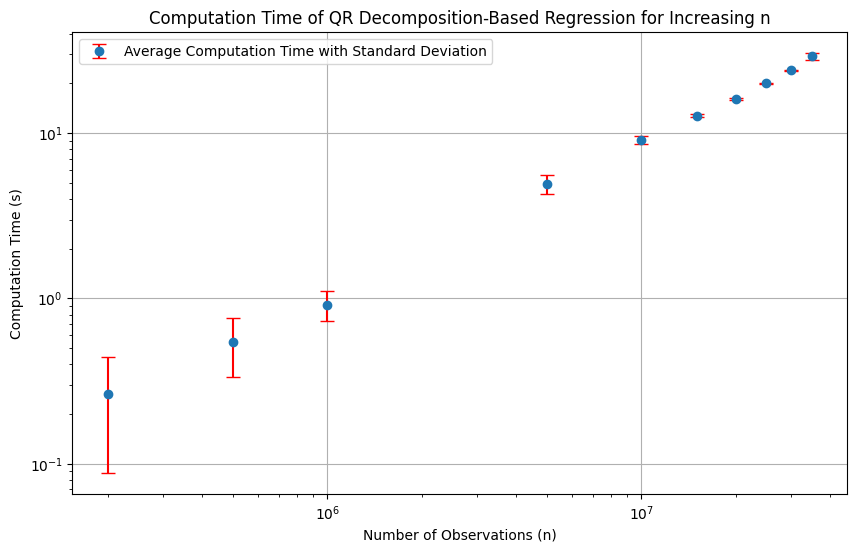

In [78]:
plot_benchmark_results(results_numpy_df["n_samples"], results_numpy_df["mean_time"], results_numpy_df["std_time"])

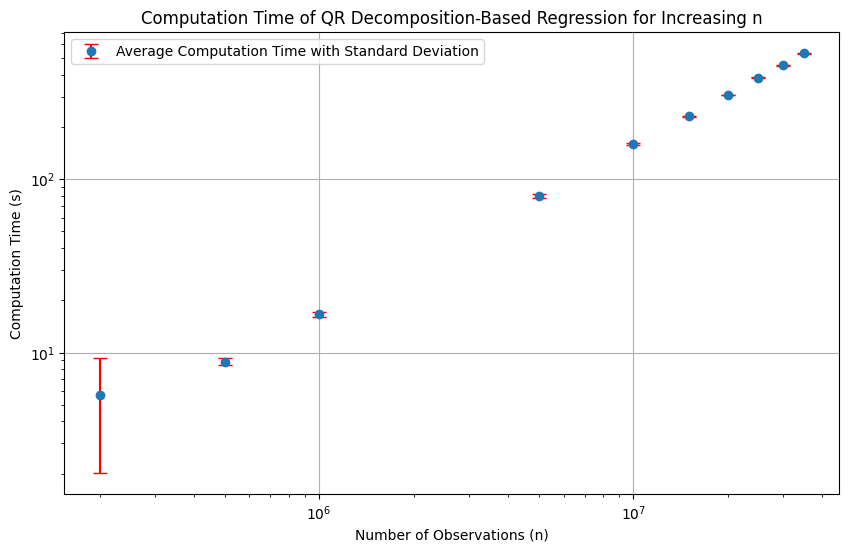

In [79]:
plot_benchmark_results(results_point_final["n_samples"], results_point_final["mean_time"], results_point_final["std_time"])

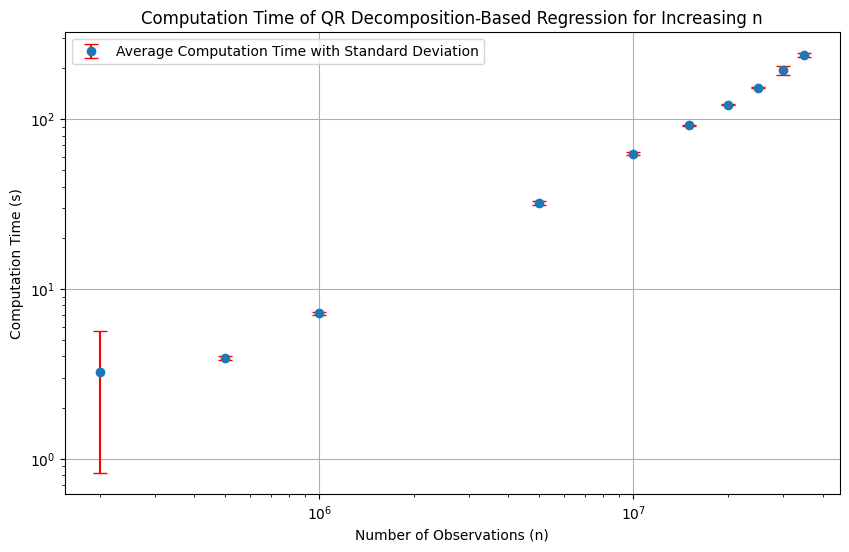

In [80]:
plot_benchmark_results(results_spark_final["n_samples"], results_spark_final["mean_time"], results_spark_final["std_time"])